In [20]:
from qiskit.transpiler.coupling import CouplingMap

import numpy as np


def pretty_print(edge_list, simple=False):
    if simple:
        temp = list(edge_list)
        temp2 = []
        for i, j in temp:
            if not (j, i) in temp2:
                temp2.append((i, j))
        edge_list = temp2

    x = CouplingMap(edge_list)

    # black magic errors when I modify the draw function directly in the CouplingMap file so Im just copying the code here to make it work
    import pydot
    from PIL import Image
    import io

    formatter2 = lambda _: dict(dir="none")
    dot_str = x.graph.to_dot(edge_attr=formatter2, graph_attr={"size": "0"})
    dot = pydot.graph_from_dot_data(dot_str)[0]
    png = dot.create_png(prog="sfdp")
    pdf = dot.create_pdf(prog="sfdp")
    # png = dot.create_png(prog="neato")
    return Image.open(io.BytesIO(png))

In [16]:
# define corral
def corral(num_snails=32, num_levels=2):
    """returns edge list of a corral of size specified
    snails are nodes, edges are qubits"""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(num_levels):
            snail_edge_list.append((snail0, snail1 % num_snails))
    return snail_edge_list

[(0, 1), (0, 1), (1, 2), (1, 2), (2, 3), (2, 3), (3, 4), (3, 4), (4, 5), (4, 5), (5, 6), (5, 6), (6, 7), (6, 7), (7, 8), (7, 8), (8, 9), (8, 9), (9, 10), (9, 10), (10, 11), (10, 11), (11, 12), (11, 12), (12, 13), (12, 13), (13, 14), (13, 14), (14, 15), (14, 15), (15, 16), (15, 16), (16, 17), (16, 17), (17, 18), (17, 18), (18, 19), (18, 19), (19, 20), (19, 20), (20, 21), (20, 21), (21, 22), (21, 22), (22, 23), (22, 23), (23, 24), (23, 24), (24, 25), (24, 25), (25, 26), (25, 26), (26, 27), (26, 27), (27, 28), (27, 28), (28, 29), (28, 29), (29, 30), (29, 30), (30, 31), (30, 31), (31, 0), (31, 0)]


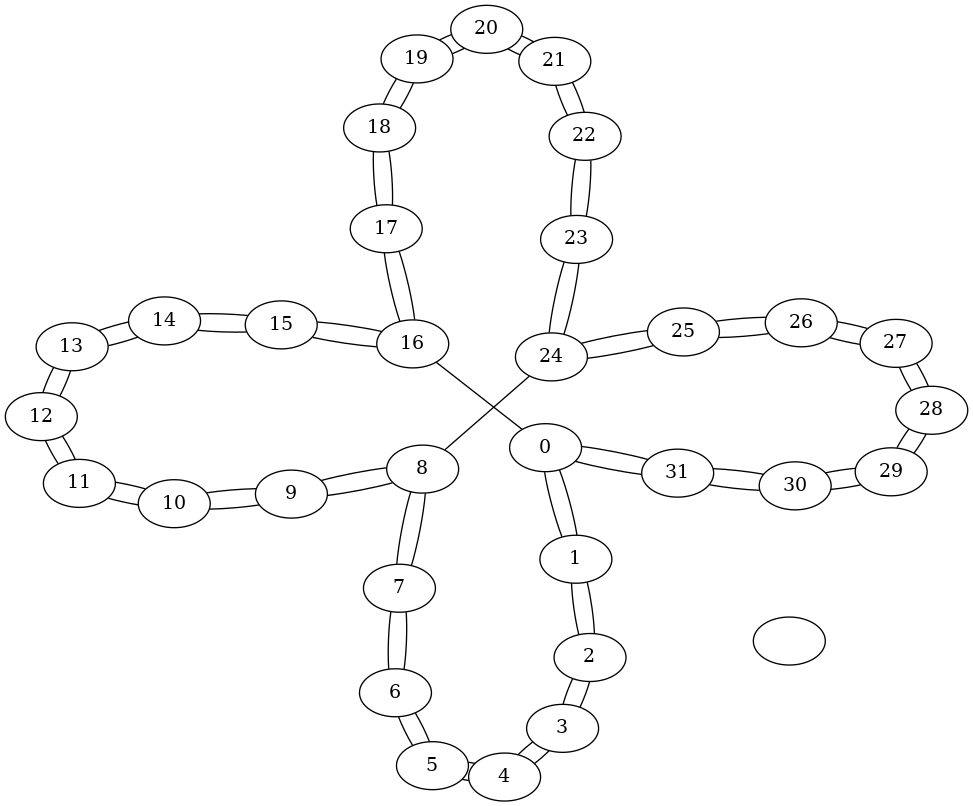

In [27]:
from src.clonk.backend_utils.mock_backends.Corral_backend_v1 import FakeCorral

c = FakeCorral()
corral_32 = corral()
print(corral_32)

new_edges = c.divideCorralK_math(corral_32, 32, 2)
corral_32 = np.append(corral_32, new_edges, axis=0)

display(pretty_print(corral_32))
